## Spectral Analysis of Sensor Data - Automated Processing Pipeline

- Author: Rui Pestana (NESTER), Pedro Costa (ISEL)
- Project: NESTER
- Date: 15/05/2025
- Copyright © 2025 Rui Pestana (NESTER), Pedro Costa (ISEL) - MIT License

Description:
This script performs spectral analysis on sensor data using Fast Fourier Transform (FFT)
and autocorrelation techniques. Designed for identifying fundamental frequencies and 
harmonics in time-series data from sensors.

Key Functionalities:
- Data loading and preprocessing of CSV sensor recordings
- Windowed analysis with configurable time windows
- Autocorrelation-based fundamental frequency detection
- FFT spectral analysis with harmonic identification
- Automated generation of diagnostic plots

Inputs:
- CSV files containing time-series sensor data
- Configured columns: ["ABS_MU", "ABS_AM1", "ABS_AM2", "ABS_DM1"]

Outputs:
- Autocorrelation plots for each sensor window
- Frequency spectrum plots with harmonic annotations

License:
Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

Dependencies:
- Python 3.8+
- pandas, numpy, matplotlib, scipy

Parameters:
- Sampling interval: 15 minutes
- Analysis window: 50 hours
- Window step: 25 hours
- FFT padding factor: 8x




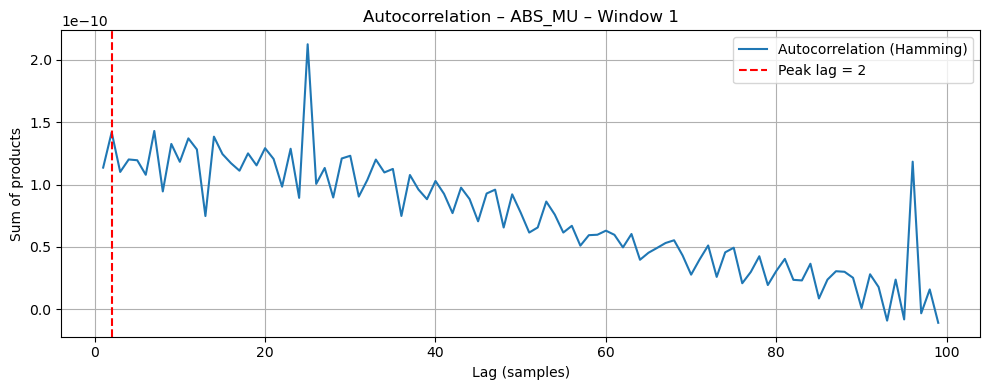

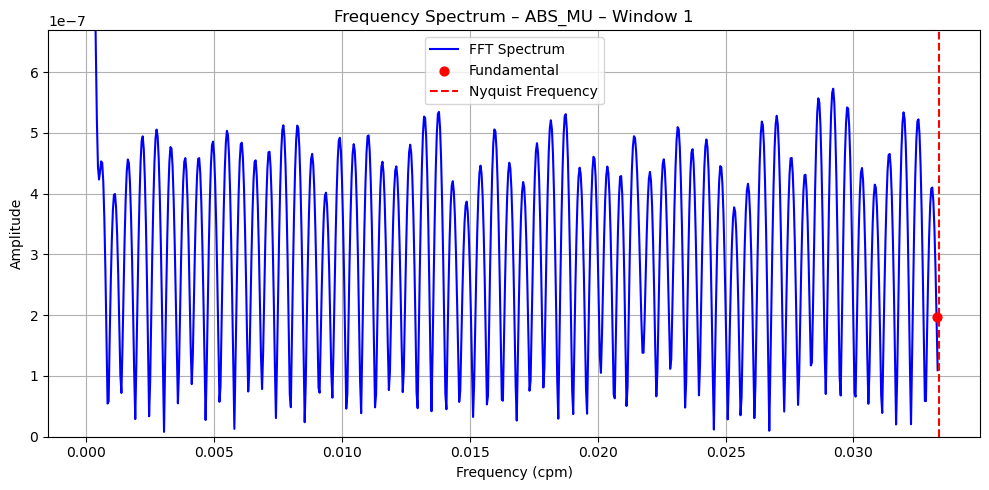

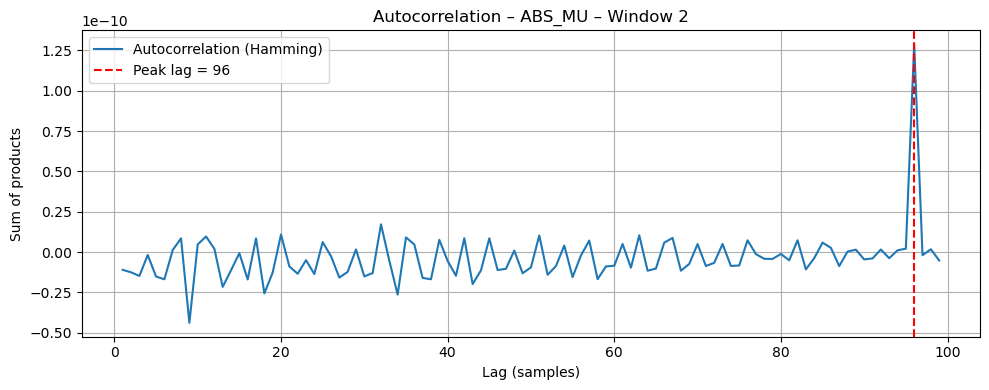

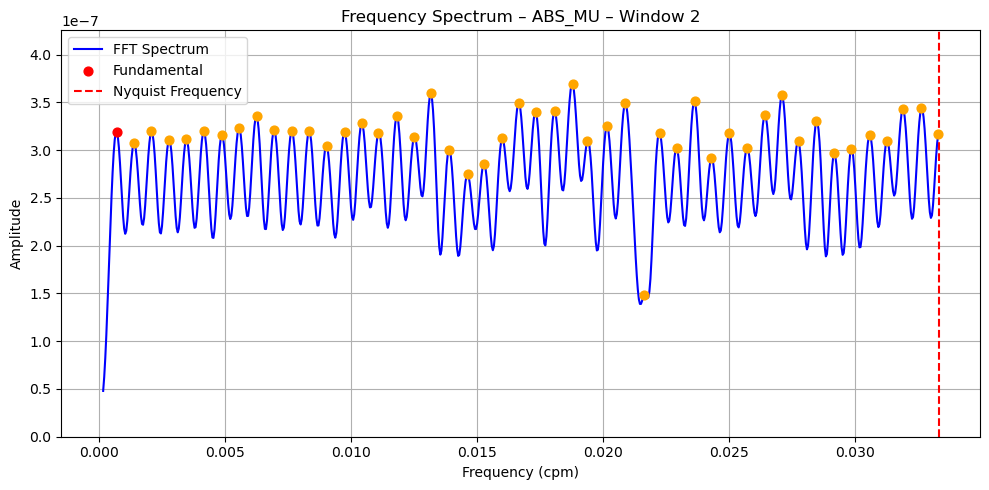

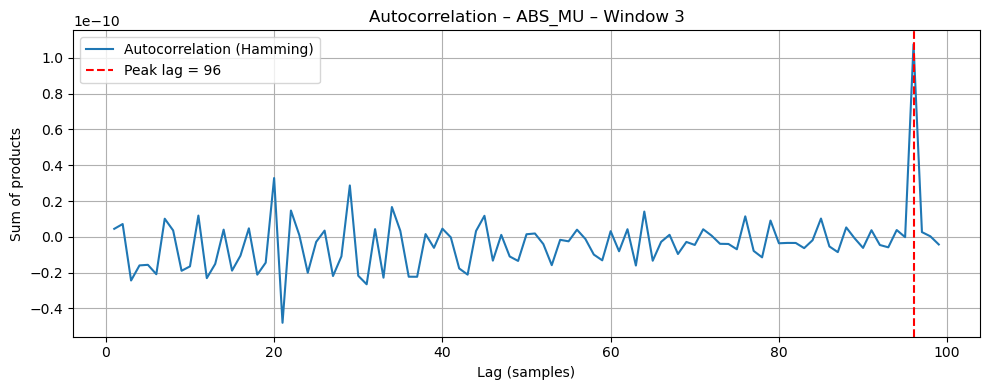

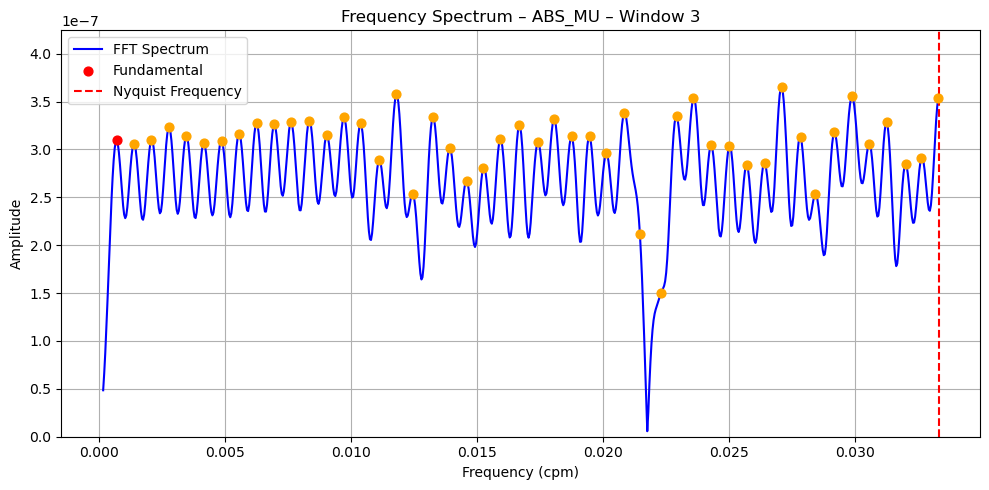

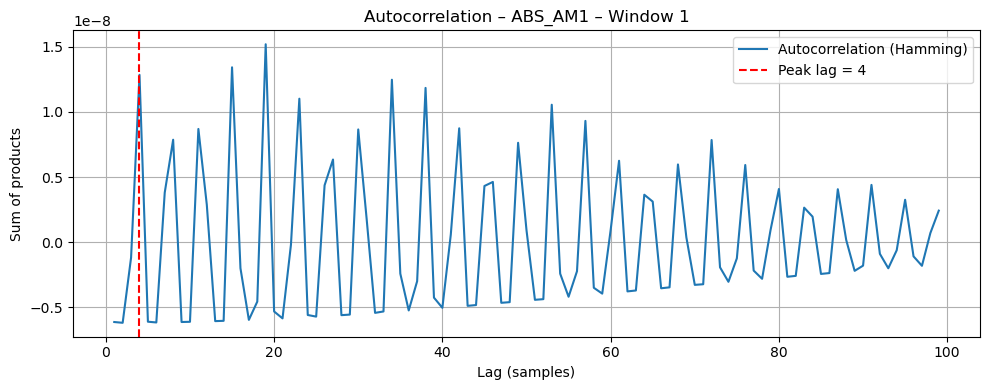

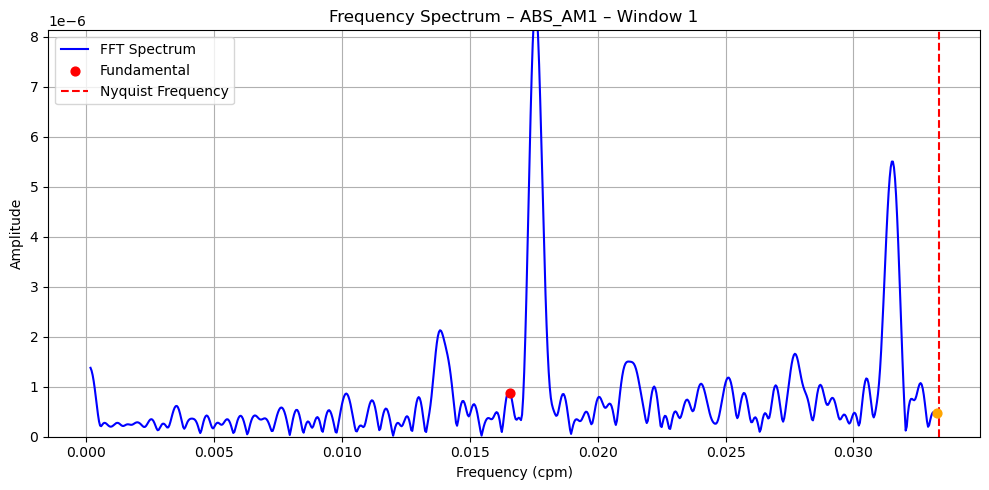

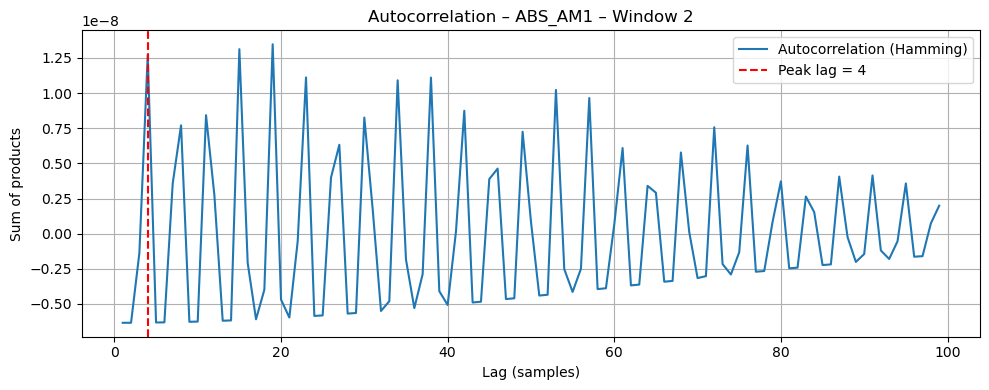

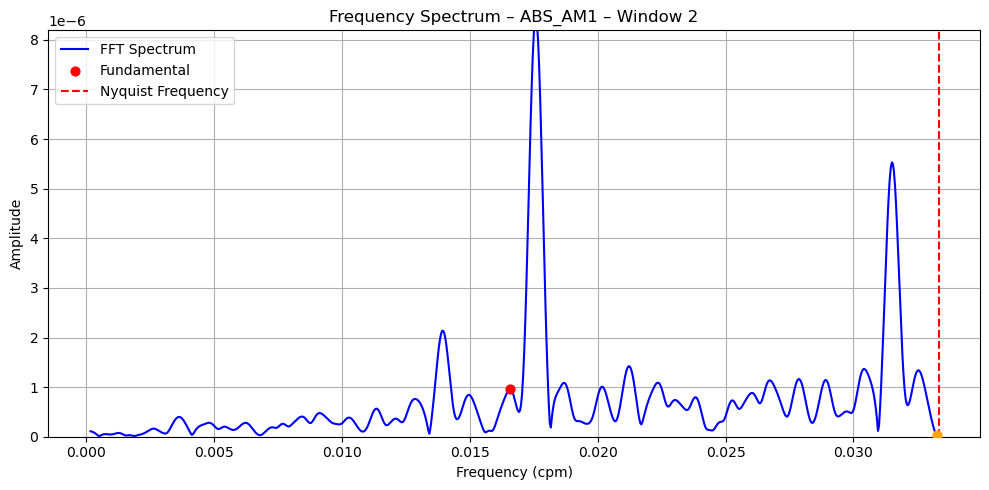

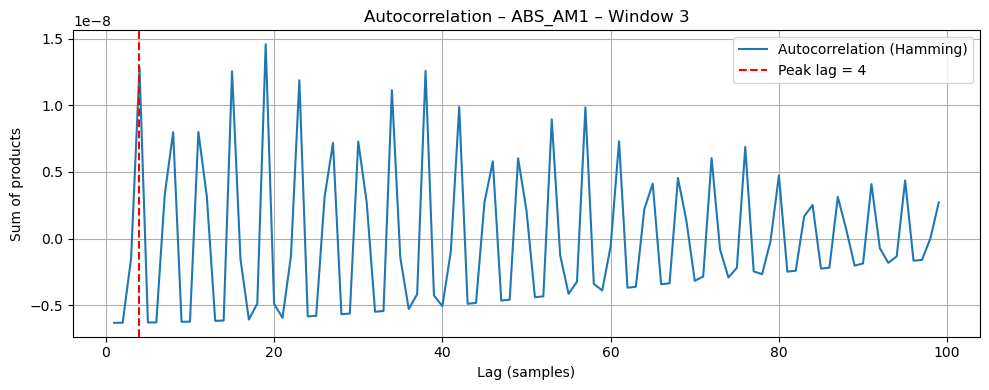

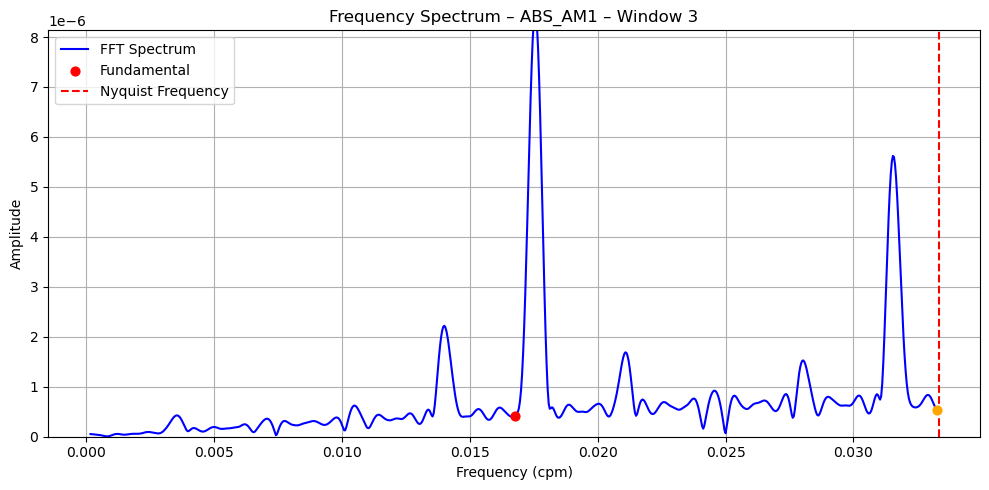

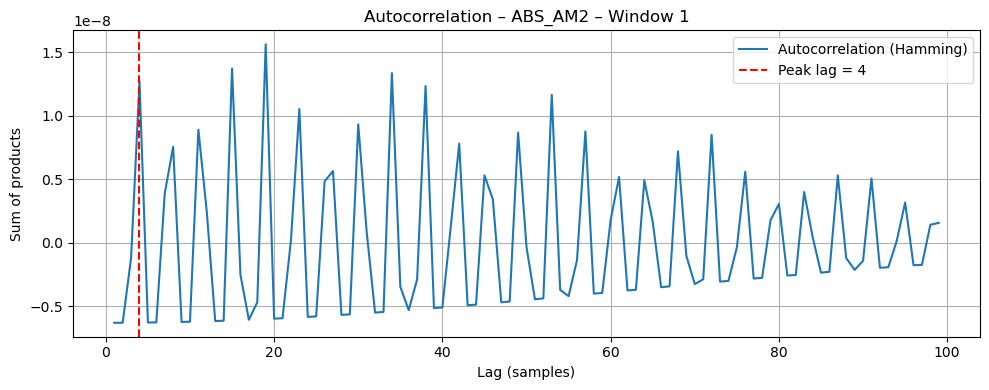

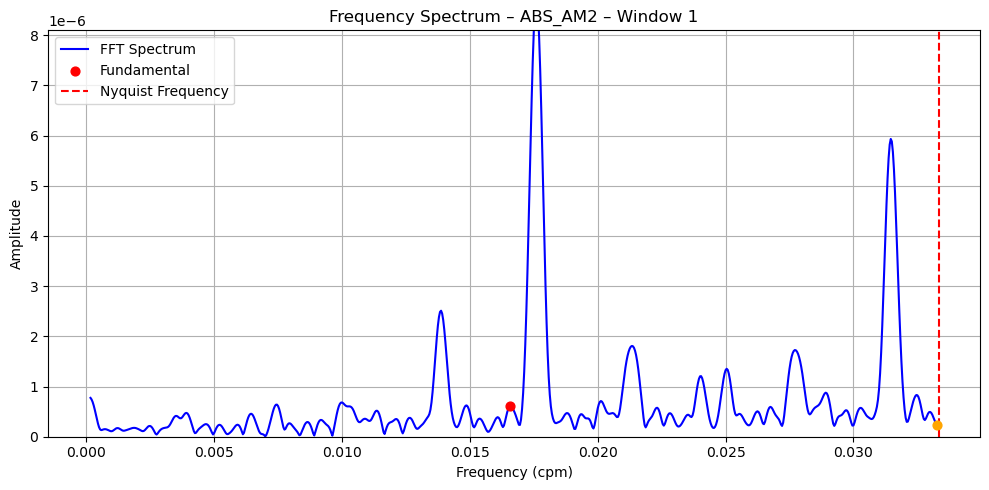

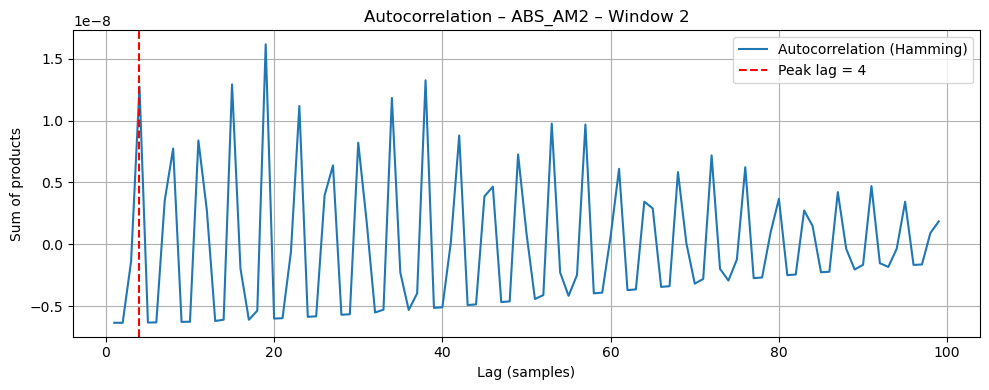

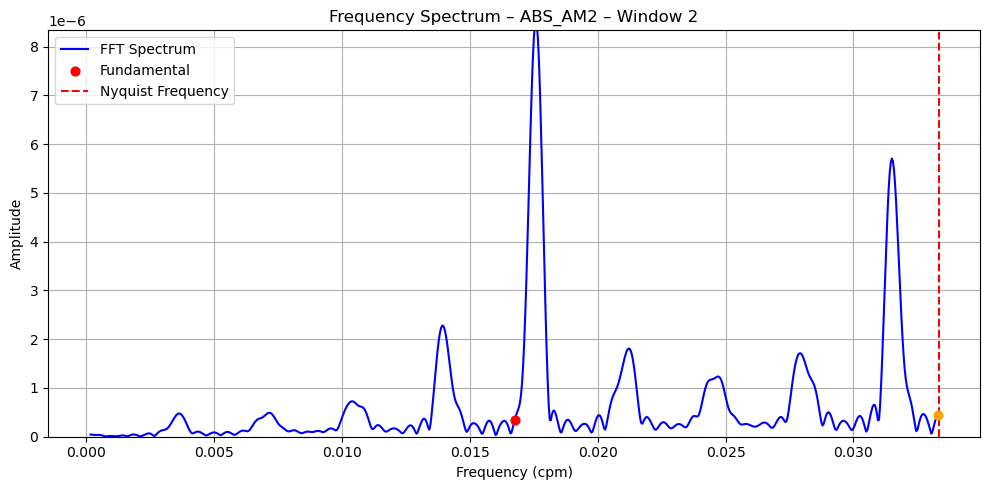

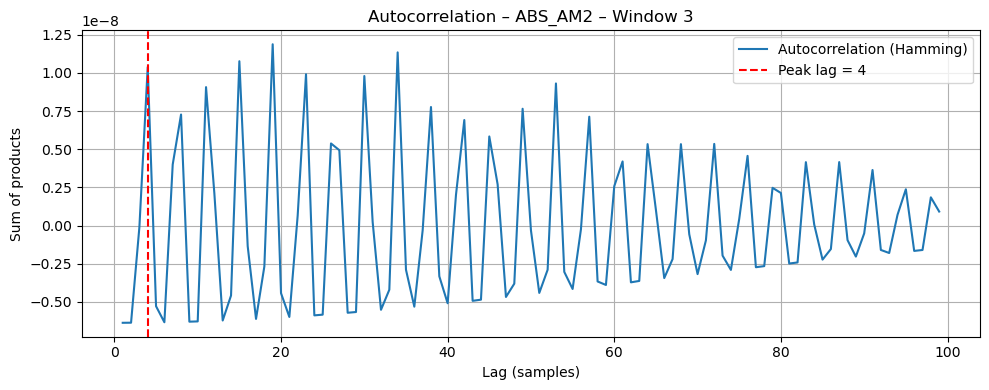

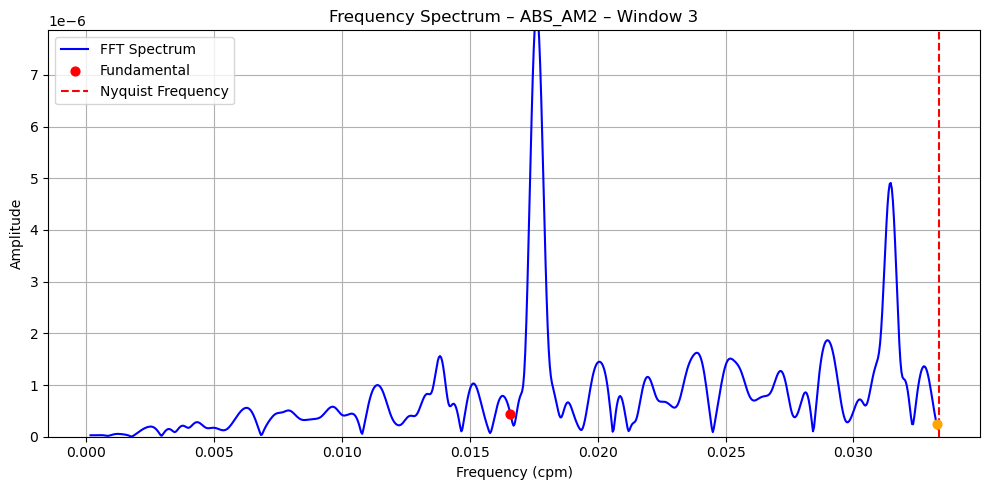

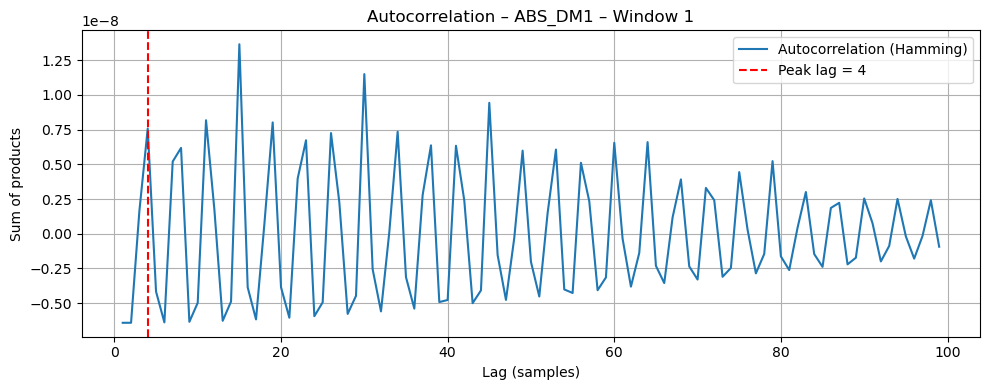

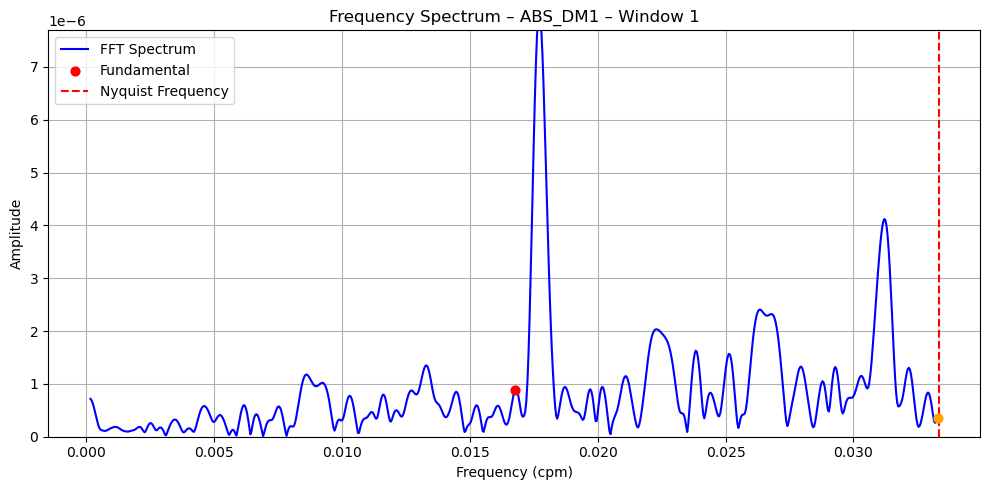

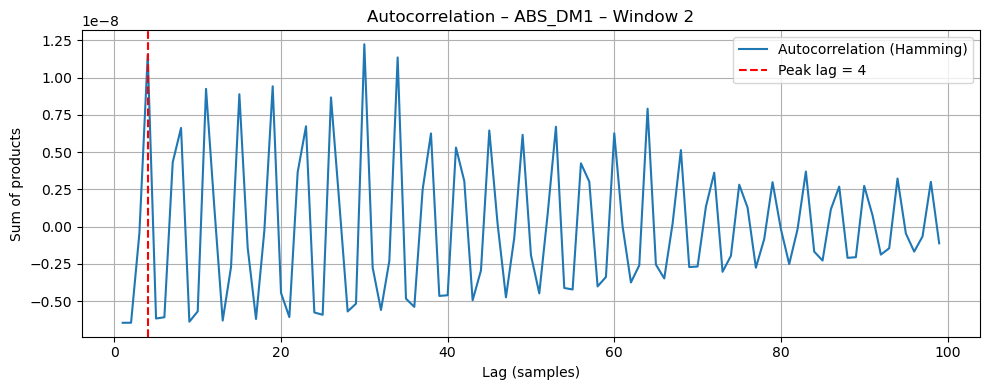

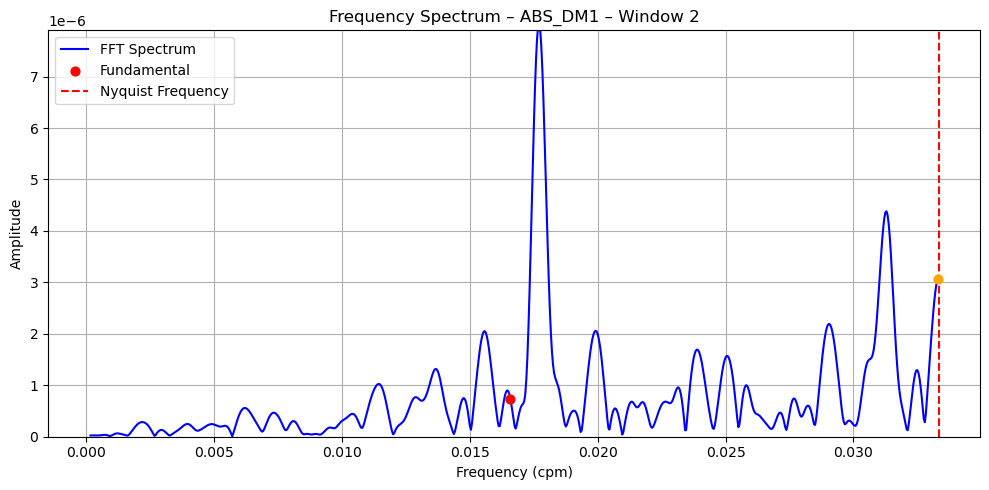

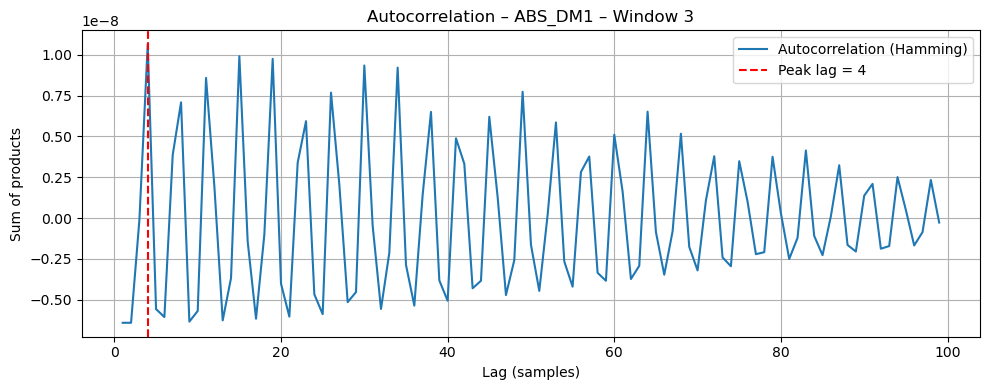

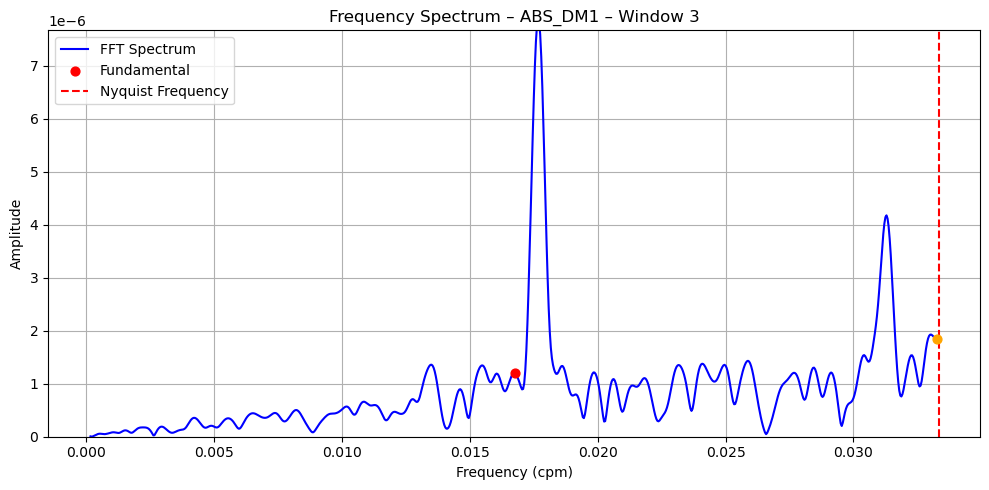

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.signal import find_peaks

# === DATA LOADING ===
# Define file path and columns of interest
file_path = r".\Dados\Dados_DL1\all_variables-DL1-rp1_A1P-REF-ABS.csv"
columns = ["ABS_MU", "ABS_AM1", "ABS_AM2", "ABS_DM1"]

# Read CSV file and preprocess data
df = pd.read_csv(file_path)
# Extract relevant columns and remove missing values
data = df[columns].dropna().reset_index(drop=True)

# === ANALYSIS PARAMETERS ===
T_min = 15                      # Sampling interval in minutes
T_sec = T_min * 60             # Convert to seconds
fs = 1 / T_min                 # Sampling frequency (cycles per minute, cpm)
nyquist_freq = fs / 2          # Nyquist frequency (maximum detectable frequency)
padding_factor = 8             # Zero-padding factor for FFT resolution
samples_per_hour = 60 // T_min # Number of samples per hour
window_minutes = 50 * 60       # Window size (50 hours converted to minutes)
step_minutes = 25 * 60         # Step size between windows (25 hours in minutes)
window_size = window_minutes // T_min  # Window size in samples
step_size = step_minutes // T_min      # Step size in samples


# === MAIN PROCESSING LOOP ===
# Iterate through each sensor column
for col in columns:
    signal_full = data[col].to_numpy()  # Convert column to numpy array
    total_length = len(signal_full)     # Total data points available
    window_number = 1                   # Initialize window counter

    # Slide window through the data with defined step size
    for start in range(0, total_length, step_size):
        end = start + window_size
        if end > total_length: # Skip incomplete final window
            break

        # Extract current window of data
        signal = signal_full[start:end]
        N = len(signal) # Number of samples in current window

        # === AUTOCORRELATION ANALYSIS ===
        # Preprocess signal
        signal = signal - np.mean(signal)  # Remove DC component
        signal = signal * np.hamming(N)    # Apply Hamming window to reduce spectral leakage 

        # Calculate autocorrelation for different lags
        autocorr = [np.dot(signal[:-lag], signal[lag:]) for lag in range(1, N // 2)]
        autocorr = np.array(autocorr)

        # Detect peaks in autocorrelation
        peaks, _ = find_peaks(autocorr, distance=5)  # Find peaks with minimum 5-sample separation
        
        threshold = 0.5 * np.max(autocorr)          # Set threshold at 50% of max amplitude
        
        # Determine dominant lag (fundamental period)
        lag_peak = peaks[0] + 1 if len(peaks) > 0 else np.argmax(autocorr) + 1
        for peak in peaks:  # Find first significant peak above threshold
            if autocorr[peak] >= threshold:
                lag_peak = peak + 1
                break

        # Calculate fundamental frequency (cycles per minute)
        f0 = 1 / (lag_peak * T_min) 

        # === PLOT AUTOCORRELATION RESULTS ===
        plt.figure(figsize=(10, 4))
        plt.plot(range(1, len(autocorr)+1), autocorr, label="Autocorrelation (Hamming)")
        plt.axvline(x=lag_peak, color='red', linestyle='--', label=f"Peak lag = {lag_peak}")
        plt.title(f"Autocorrelation – {col} – Window {window_number}")
        plt.xlabel("Lag (samples)")
        plt.ylabel("Sum of products")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # === FREQUENCY ANALYSIS WITH FFT ===
        # Apply zero-padding to improve frequency resolution
        padded_len = padding_factor * N
        signal_padded = np.pad(signal, (0, padded_len - N), mode='constant')

        
        # Compute FFT and frequency bins
        fft_result = fft(signal_padded)
        freqs = fftfreq(padded_len, T_min)[:padded_len // 2]  # Frequency axis in cpm
        amplitude = 2.0 / N * np.abs(fft_result[:padded_len // 2])  # Scale amplitude

        # Create spectrum DataFrame and filter
        spectrum = pd.DataFrame({"Frequency (cpm)": freqs, "Amplitude": amplitude})
        spectrum = spectrum[spectrum["Frequency (cpm)"] > 0]  # Remove DC component
        filtered = spectrum[spectrum["Frequency (cpm)"] <= nyquist_freq].reset_index(drop=True)  # Apply Nyquist limit
        filtered = filtered.iloc[3:].reset_index(drop=True)  # Skip first 3 low-frequency bins


        # === HARMONIC ANALYSIS ===
        harmonics = []
        delta = 0.0001  # Frequency search window around expected harmonic
        n = 1  # Harmonic multiplier
        
        # Search for harmonics up to Nyquist frequency
        while f0 * n <= nyquist_freq:
            f_h = f0 * n  # Expected harmonic frequency
            # Find spectral components near expected harmonic
            window = filtered[(filtered["Frequency (cpm)"] >= f_h - delta) &
                              (filtered["Frequency (cpm)"] <= f_h + delta)]
            if not window.empty:
                # Identify strongest component in search window
                idx_peak = window["Amplitude"].idxmax()
                f_match = filtered.loc[idx_peak, "Frequency (cpm)"]
                a_match = filtered.loc[idx_peak, "Amplitude"]
                harmonics.append((f_match, a_match, n))
            n += 1

        # === PLOT FREQUENCY SPECTRUM ===
        plt.figure(figsize=(10, 5))
        plt.plot(filtered["Frequency (cpm)"], filtered["Amplitude"], label="FFT Spectrum", color='blue')
        # Mark harmonics with different colors
        for f, a, n in harmonics:
            color = 'red' if n == 1 else 'orange'
            label_h = "Fundamental" if n == 1 else None
            plt.scatter(f, a, color=color, s=40, label=label_h, zorder=5)
        plt.axvline(x=nyquist_freq, color='red', linestyle='--', label="Nyquist Frequency")

        # Set dynamic y-axis limit based on data distribution
        upper_limit = np.percentile(filtered["Amplitude"], 99) * 1.2
        plt.ylim(0, upper_limit)

        plt.title(f"Frequency Spectrum – {col} – Window {window_number}")
        plt.xlabel("Frequency (cpm)")
        plt.ylabel("Amplitude")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

        window_number += 1  # Increment window counter for next iteration


Sensor Data Spectrogram Generation

Description:
Generates time-frequency spectrograms from sensor data using Short-Time Fourier Transform (STFT).
Creates a combined visualization of multiple sensors' spectral content over time.

Key Features:
- Multi-channel parallel processing
- Adaptive windowing with overlap
- Noise-reduced spectral analysis
- Unified visualization with shared frequency axis

Inputs:
- CSV file containing time-series sensor data
- Columns analyzed: ["ABS_MU", "ABS_AM1", "ABS_AM2", "ABS_DM1"]

Outputs:
- Combined 4-panel spectrogram plot (PNG format)
- Dictionary containing computed spectral data (frequency × time × sensor)

Parameters:
- Temporal Resolution:
  - T_min: 15 (sampling interval in minutes)
  - Window: 50 hours (analysis duration)
  - Step: 25 hours (window overlap)
- Spectral Analysis:
  - Padding factor: 8× (FFT zero-padding)
  - Nyquist limit: 0.0333 cpm (1/(2*T_min))
  - Dynamic range: 99th percentile amplitude cutoff

Dependencies:
- pandas >= 1.3.0
- numpy >= 1.21.0
- matplotlib >= 3.4.0
- scipy >= 1.7.0

License:
MIT License (see full text in header)


C:\Users\Pedro\AppData\Local\Temp\ipykernel_24220\764431868.py:87: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.95, 0.96])


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/data/Spectrogram_Combined_DL1_v2.png'

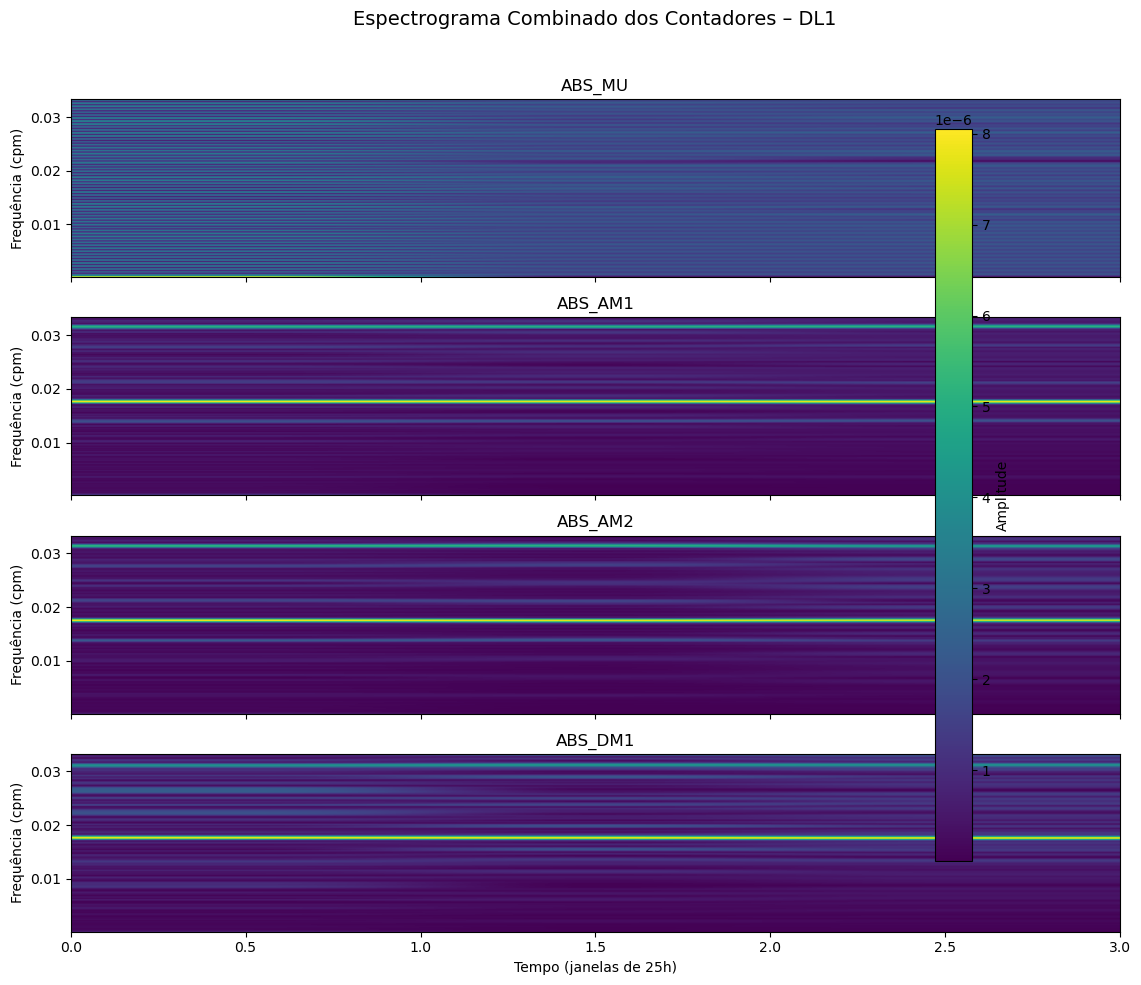

In [8]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.signal import find_peaks

# === GLOBAL PARAMETERS ===
# File and data configuration
file_path = r".\Dados\Dados_DL1\all_variables-DL1-rp1_A1P-REF-ABS.csv"
columns = ["ABS_MU", "ABS_AM1", "ABS_AM2", "ABS_DM1"]  # Sensor columns to analyze

# Temporal parameters
T_min = 15                     # Sampling interval in minutes
T_sec = T_min * 60            # Convert to seconds
fs = 1 / T_min                # Sampling frequency (cycles per minute)
nyquist_freq = fs / 2         # Maximum detectable frequency
padding_factor = 8            # Zero-padding multiplier for FFT resolution

# Window configuration
samples_per_hour = 60 // T_min  # Data points per hour
window_minutes = 50 * 60      # Analysis window duration (50 hours)
step_minutes = 25 * 60        # Window step size (25 hours)
window_size = window_minutes // T_min  # Window size in samples
step_size = step_minutes // T_min      # Step size in samples

# === DATA LOADING ===
# Read and preprocess raw data
df = pd.read_csv(file_path)
# Clean data by removing missing values and resetting index
data = df[columns].dropna().reset_index(drop=True)

# === SPECTROGRAM DATA PREPARATION ===
spectrogram_data = {}         # Dictionary to store spectral data
freqs_reference = None        # Reference frequency array for alignment

# Process each sensor channel independently
for col in columns:
    signal_full = data[col].to_numpy()  # Convert to numpy array
    total_length = len(signal_full)     # Total available data points
    spectra = []                        # List to store window spectra
    
    # Sliding window processing
    for start in range(0, total_length, step_size):
        end = start + window_size
        if end > total_length:  # Skip incomplete final window
            break

        # Window extraction and preprocessing
        signal = signal_full[start:end]
        N = len(signal)                # Current window sample count
        
        # Signal conditioning
        signal = signal - np.mean(signal)  # Remove DC offset
        signal = signal * np.hamming(N)    # Apply window function
        
        # Zero-padding for frequency resolution
        padded_len = padding_factor * N
        signal_padded = np.pad(signal, (0, padded_len - N), mode='constant')
        
        # FFT computation
        fft_result = fft(signal_padded)
        freqs = fftfreq(padded_len, T_min)[:padded_len // 2]  # Frequency bins
        amplitude = 2.0 / N * np.abs(fft_result[:padded_len // 2])  # Normalized amplitude
        
        # Spectrum filtering and formatting
        spectrum = pd.DataFrame({
            "Frequency (cpm)": freqs,
            "Amplitude": amplitude
        })
        spectrum = spectrum[spectrum["Frequency (cpm)"] > 0]  # Remove DC component
        filtered = spectrum[spectrum["Frequency (cpm)"] <= nyquist_freq].reset_index(drop=True)  # Apply Nyquist limit
        filtered = filtered.iloc[3:].reset_index(drop=True)   # Remove low-frequency noise
        
        # Set reference frequency array (first channel defines frequencies)
        if freqs_reference is None:
            freqs_reference = filtered["Frequency (cpm)"].values
        
        # Store amplitude values for current window
        spectra.append(filtered["Amplitude"].values)
    
    # Store transposed spectrogram data (frequency × time)
    spectrogram_data[col] = np.array(spectra).T

# === COMBINED SPECTROGRAM PLOT ===
# Create multi-panel figure
fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True, sharey=True)

# Generate time axis labels (25-hour increments)
freqs = freqs_reference
windows = [f"{i * 25}" for i in range(spectrogram_data["ABS_MU"].shape[1])]

# Plot each sensor's spectrogram
for i, col in enumerate(columns):
    ax = axes[i]
    # Create spectrogram image (time vs frequency vs amplitude)
    im = ax.imshow(spectrogram_data[col], 
                   origin='lower',     # Place [0,0] at bottom-left
                   aspect='auto',     # Automatic aspect ratio
                   extent=[0, len(windows), freqs[0], freqs[-1]],  # Axis limits
                   cmap='viridis')    # Perceptually uniform colormap
    
    ax.set_title(f"{col}", fontsize=12)
    ax.set_ylabel("Frequency (cpm)")

# Configure shared axis labels
axes[-1].set_xlabel("Time (25-hour windows)")
fig.suptitle("Combined Spectrogram of Counters - DL1", fontsize=14)

# Add shared colorbar
cbar = fig.colorbar(im, ax=axes.ravel().tolist(), 
                    orientation='vertical', 
                    shrink=0.95)
cbar.set_label("Amplitude")

# Optimize layout and display
plt.tight_layout(rect=[0, 0, 0.95, 0.96])
#plt.savefig("/mnt/data/Spectrogram_Combined_DL1_v2.png", dpi=300)
plt.show()
